In [1]:
import matplotlib.pyplot as plt
def show_grayscale(rows, columns, at, pixel_array, sz):
    import scipy
    ax = plt.subplot(rows, columns, at)
    interp_array = scipy.ndimage.zoom(pixel_array.reshape(sz,sz), 4.0, order=5)
    plt.imshow(interp_array.reshape(sz*4, sz*4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

def show_original_decoded(original, decoded, sz):
    n = 10  # how many digits we will display
    plt.figure(figsize=(n*2, 4))
    for i in range(n):
        show_grayscale(2, n, i+1, original[i], sz)
        show_grayscale(2, n, i+1+n, decoded[i], sz)
    plt.show(block=True)

13413
100


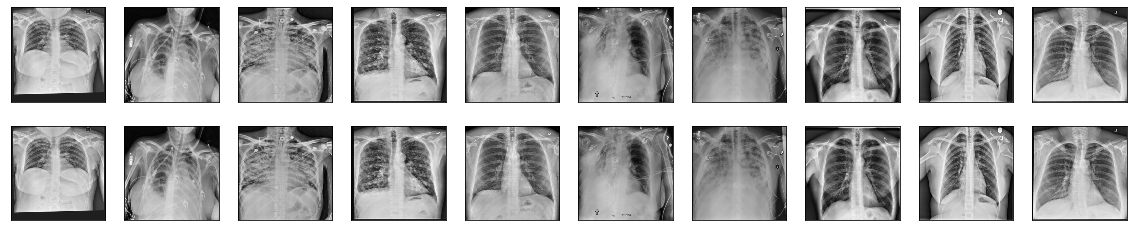

In [3]:
import glob
import imageio
import numpy as np
import cv2
from skimage.transform import resize
pngs = glob.glob("e:/github/lin*/COVID*/data/train/*.png")
print(len(pngs))
sz,imgs=256,[]
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
for png in pngs[:100]:
    img = imageio.imread(png)
    if len(img.shape) > 2:
        continue
    img = clahe.apply(img)
    img = resize(img, (sz,sz))
    width = np.max(img) - np.min(img)
    img = img - np.min(img)
    img = img/width
    img = img.reshape((sz,sz,1))
    imgs = imgs + [img]
    if len(imgs) % 100 == 0:
        print(len(imgs))
show_original_decoded(imgs[:10], imgs[:10], sz)

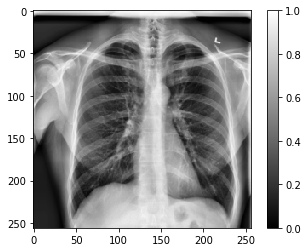

In [4]:
plt.figure()
plt.imshow(imgs[7].reshape((sz,sz)), cmap=plt.cm.gray)
plt.colorbar()
plt.grid(False)
plt.show()

In [5]:
from keras.layers import Dense, Input, SpatialDropout2D
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import LocallyConnected2D, ZeroPadding2D
from keras.layers import MaxPooling2D, UpSampling2D
from keras.layers import Reshape, Conv2DTranspose
from keras.layers import ActivityRegularization
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon



Using TensorFlow backend.


In [10]:
def build_autoencoder(sz, optimizer, loss):

    # create encoder side
    input_img = Input(shape=(sz,sz,1))
    x = Conv2D(16, (3,3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = SpatialDropout2D(0.1)(x)
    x = Conv2D(16, (3,3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2,2), padding='same')(x)    
    x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = LocallyConnected2D(4, (3,3))(x)
    x = ZeroPadding2D(padding=(1,1))(x)
    # x = MaxPooling2D((2,2), padding='same')(x)
    encoded_layer = ActivityRegularization(l1=0.0e-4,l2=0.0e-4)(x)

    # shape info needed to build decoder model
    shape = K.int_shape(encoded_layer)
    print(shape)

    # generate latent vector Q(z|X)
    latent_dim = 24
    x = Flatten()(encoded_layer)
    x = Dense(latent_dim, activation='relu')(x)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)

    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])


    encoder = Model(input_img, [z_mean, z_log_var, z], name='encoder')
    encoder.summary()
    # plot_model(encoder, to_file='data\dicom_encoder.png', show_shapes=True)

    # TODO: add threshold layer for sparsity test



    # build decoder model
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
    x = Reshape((shape[1], shape[2], shape[3]))(x)

    x = LocallyConnected2D(4, (3,3))(x)
    x = ZeroPadding2D(padding=(1,1))(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(64, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(32, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(32, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(16, (3,3), activation='relu', padding='same')(x)
    #x = UpSampling2D((2,2))(x)
    decoded_layer = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)
    decoder = Model(latent_inputs, decoded_layer)
    decoder.summary()
    # plot_model(decoder, to_file='data\dicom_decoder.png', show_shapes=True)

    autoencoder_output = decoder(encoder(input_img)[2])
    autoencoder = Model(input_img, autoencoder_output, name='ae')
    autoencoder.compile(optimizer=optimizer, loss=loss)
    autoencoder.summary()
    # plot_model(autoencoder, to_file='data\dicom_autoencoder.png', show_shapes=True)

    return autoencoder, encoder, decoder


In [11]:
autoencoder, encode_only, decode_only = build_autoencoder(sz, 'adadelta', 
    # 'binary_crossentropy')
    'mean_squared_error')

(None, 16, 16, 4)
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 256, 256, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 128, 128, 16) 0           conv2d_8[0][0]                   
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 128, 128, 32) 4640        max_pooling2d_7[0][0]            
__________________________________________________________________________

In [12]:
import numpy as np
test_count = int(len(imgs)/10)
x_test = imgs[:test_count]
x_train = imgs[test_count:]
x_train, x_test = np.array(x_train), np.array(x_test)
print(x_train.shape, x_test.shape)

(90, 256, 256, 1) (10, 256, 256, 1)


In [13]:
autoencoder.fit(x_train, x_train, 
                epochs=675, batch_size=128, 
                shuffle=True, validation_data=(x_test,x_test))

Train on 90 samples, validate on 10 samples
Epoch 1/675
90/90 [==============================] - 8s 91ms/step - loss: 0.0679 - val_loss: 0.0583
Epoch 2/675
90/90 [==============================] - 0s 5ms/step - loss: 0.0678 - val_loss: 0.0582
Epoch 3/675
90/90 [==============================] - 0s 5ms/step - loss: 0.0678 - val_loss: 0.0581
Epoch 4/675
90/90 [==============================] - 0s 5ms/step - loss: 0.0677 - val_loss: 0.0579
Epoch 5/675
90/90 [==============================] - 0s 5ms/step - loss: 0.0676 - val_loss: 0.0578
Epoch 6/675
90/90 [==============================] - 0s 5ms/step - loss: 0.0675 - val_loss: 0.0577
Epoch 7/675
90/90 [==============================] - 0s 5ms/step - loss: 0.0675 - val_loss: 0.0576
Epoch 8/675
90/90 [==============================] - 0s 5ms/step - loss: 0.0674 - val_loss: 0.0575
Epoch 9/675
90/90 [==============================] - 0s 5ms/step - loss: 0.0674 - val_loss: 0.0574
Epoch 10/675
90/90 [==============================] - 0s 5ms/ste

KeyboardInterrupt: 

In [ ]:
encode_only_imgs = encode_only.predict(x_test[:10])
for n in range(10):
    print("shape of encoded = ", encode_only_imgs[2].shape)
    hist, bins = np.histogram(encode_only_imgs[2])
    print(hist)
    print(bins)

In [ ]:
decoded_imgs = decode_only.predict(encode_only_imgs[2])
show_original_decoded(x_test, decoded_imgs, sz)